# Fintech545 Assignment4
## October 14, 2022

In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize 
from ft545 import myfunctions

### 1. Problem 1
Use the data in problem1.csv. Fit a normal Distribution and a Generalized T distribution to this data. Calculate the VaR and the ES for both fiited distributions.

Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

In [2]:
data = pd.read_csv("problem1.csv")
data

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284
...,...
495,0.009279
496,-0.001121
497,0.075188
498,0.038520


#### fit T distribution

In [175]:
data1 = list(data['x'])
def MLE_T(p):
   return -1*np.sum(stats.t.logpdf(data1, df=p[0], loc = p[1],scale=p[2])) 
constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, 
                 {"type":"ineq", "fun":lambda x: x[2]})
df, loc, scale = minimize(MLE_T, x0 = (10,np.mean(data1),np.std(data1)),constraints=constraints).x
sim_T = stats.t(df=df, scale=scale).rvs(10000)

#### fit normal distribution 

In [45]:
sim_N = np.random.normal(np.mean(data1),np.std(data1),size=10000)

In [176]:
print("VaR of Normal distribution is ",myfunctions.VaR(sim_N, 0))
print("VaR of T distribution is ",myfunctions.VaR(sim_T, 0))
print("ES of Normal distribution is ",myfunctions.es(sim_N))
print("ES of T distribution is ",myfunctions.es(sim_T))

VaR of Normal distribution is  0.08174392895998123
VaR of T distribution is  0.07446901701156956
ES of Normal distribution is  0.10296978366696842
ES of T distribution is  0.11009921509529187


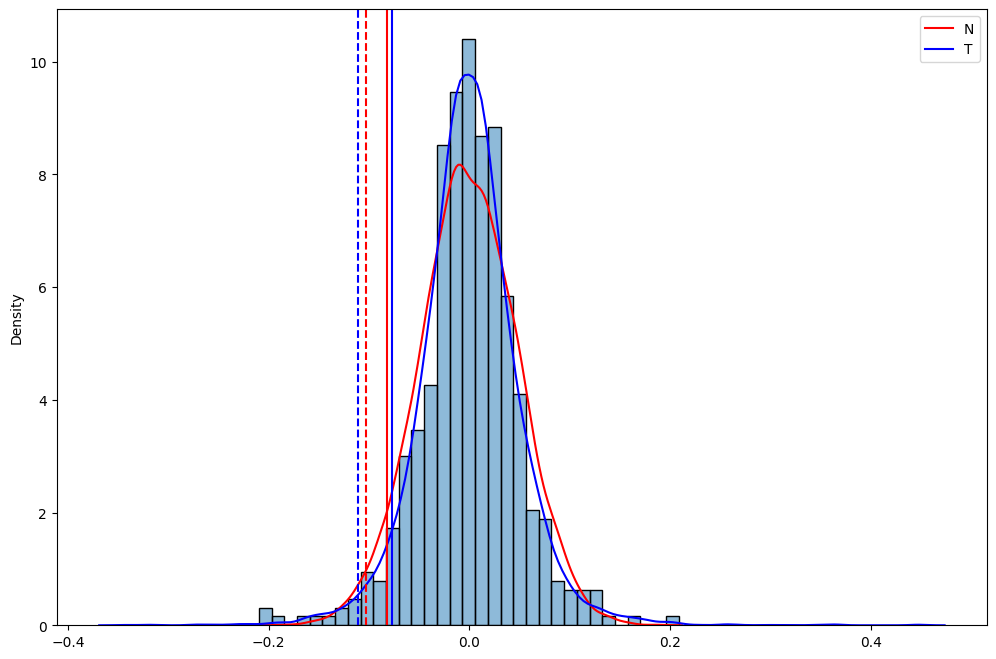

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data1, stat='density', alpha = 0.5)
sns.kdeplot(sim_N, label = "N", color = 'r')
sns.kdeplot(sim_T, label = "T", color = "b")
ax.axvline(-myfunctions.es(sim_N), color = "r", linestyle = "--")
ax.axvline(-myfunctions.es(sim_T), color = "b", linestyle = "--")
ax.axvline(-myfunctions.VaR(sim_N,0), color = "r")
ax.axvline(-myfunctions.VaR(sim_T,0), color = "b")
ax.legend()

### The solid lines are the VaR and the dotted lines are the ES. T distribution is a better fit of the graph because it has a greater kurtosis(fatter tail). The VaR of normal distribution is greater than that of T distribution and the ES of normal distribution is less than that of T distribution(loss is a positive number)

### 2. Problem 2
In your main repository, create a Library for risk management. Create modules, classes, packages, etc as you see fit. Include all the functionality we have discussed so far in class. Make sure it includes
1. Covariance estimation techniques
2. Non PSD fixes for correlation matrices
3. Simulation Methods
4. VaR calculation methods(all discusses)
5. ES calculation

Create a test suite and show that each function performs as expected

### I created a library in folder "lib". All the functions are in myfunctions.py and the test cases are under "test" folder. 

### 3. Problem 3
Use your repository from #2.
Using Portfolio.csv and Daily Prices.csv. Assume the expected return on all stocks is 0.
This file contains the stock holdings of 3 portfolios. You own each of these portfolios.
Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your total VaR and ES. Compare the results form this to your VaR from Problem3 from Week4.

In [167]:
p1 = pd.read_csv("portfolio.csv")
dp = pd.read_csv("DailyPrices.csv")

In [174]:
for k in ["A","B", "C", "total"]:
    if k!="total":
        p = p1[p1["Portfolio"]==k]
    else:
        p=p1
    cdf = []
    params = []
    cps = []
    holdings = []
    total = 0
    for i in p['Stock']:
        holdings.append(p[p['Stock']==i]['Holding'].iloc[0])
        cps.append(dp.loc[:,i].iloc[-1])
        total+=dp.loc[:,i].iloc[-1]*p[p['Stock']==i]['Holding'].iloc[0]
        returns = myfunctions.return_calculate(dp.loc[:,i])
        def MLE_T(p):
           return -1*np.sum(stats.t.logpdf(returns, df=p[0], loc = p[1],scale=p[2])) 
        constraints=({"type":"ineq", "fun":lambda x: x[0]-2}, 
                 {"type":"ineq", "fun":lambda x: x[2]})
        df, loc, scale = minimize(MLE_T, x0 = (2,np.mean(returns),np.std(returns)),constraints=constraints).x
        params.append([df,loc,scale])
        cdf.append(stats.t.cdf(returns, df = df, loc = loc, scale = scale))
    sim = myfunctions.multi_normal_sim(stats.spearmanr(np.array(cdf), axis=1)[0],1000)
    rt = []
    for i in range(len(sim)):
        rt.append(stats.t.ppf(stats.norm.cdf(sim[i]), df = params[i][0], loc = params[i][1], scale = params[i][2]))
    values = []
    for i in range(len(rt[0])):
        value = 0
        for j in range(len(rt)):
            value+=cps[j]*(1+rt[j][i])*holdings[j]
        values.append(value-total)
    print("the VaR of portfolio "+k+" is", myfunctions.VaR(np.array(values),0))
    print("the ES of portfolio "+k+" is", myfunctions.es(np.array(values)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


the VaR of portfolio A is 6088.051472116343
the ES of portfolio A is 7827.26676477154
the VaR of portfolio B is 4588.4359311812295
the ES of portfolio B is 5905.847621118043
the VaR of portfolio C is 3386.636384165054
the ES of portfolio C is 4916.092085448166
the VaR of portfolio total is 13415.849435841787
the ES of portfolio total is 18168.745384693135


### There are only little difference between the results here and the results from week4. However, simulation using Copulus should be a better fit if we have the right distribution of each stock because it does not require normality assumption.